#### https://online.stat.psu.edu/stat501/lesson/14

In [1]:
import os
import statsmodels.api as sm
from statsmodels.tsa.stattools import pacf, acf
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import Image
from statsmodels.formula.api import ols
import scipy.stats
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
filedir = 'STAT501_Lesson14'
os.listdir(filedir)

['google_stock.csv',
 'google_stock.txt',
 'employee.txt',
 'earthquakes.txt',
 'blaisdell.txt']

#### The dependency usually appears because of a temporal component. Some issues caused by autocorrelation

#### 1. Autoregressive Models

$$
y_t = \beta_0 + \beta_1 y_{t-1} + \epsilon_t
$$

For example, $\beta_0$ is 0, $\beta_1$ is 0.9, $\epsilon$ follows standard normal distribution  

In [2]:
beta0 = 0
beta1 = 0.9
y0_arr = np.zeros((20,100))
e_arr = np.random.normal(size=(20,99))
y0_arr[:,0] = 1

In [3]:
for i in range(e_arr.shape[1]):
    y0_arr[:,i+1] = beta0 + beta1 * y0_arr[:,i] + e_arr[:,i] 

<AxesSubplot:>

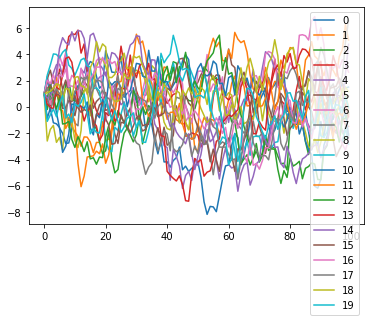

In [4]:
pd.DataFrame(y0_arr.T).plot()

ACF is a way to measure the linear relationship between an observation at time t and the observations at previous times.

In [5]:
arr_lag_0 = pd.Series(y0_arr[0,:])

In [6]:
arr_lag_1 = arr_lag_0.shift(1)
arr_lag_2 = arr_lag_0.shift(2)
arr_lag_3 = arr_lag_0.shift(3)

In [7]:
result = pd.DataFrame({
    'lag0':arr_lag_0, 
    'lag1':arr_lag_1, 
    'lag2':arr_lag_2, 
    'lag3':arr_lag_3, 
}).dropna()
result.corr()

,lag0,lag1,lag2,lag3
lag0,1.000000,0.939537,0.871944,0.806900
lag1,0.939537,1.000000,0.939009,0.871506
lag2,0.871944,0.939009,1.000000,0.938442
lag3,0.806900,0.871506,0.938442,1.000000


In [8]:
acf(arr_lag_0, nlags=3, adjusted=True)

/Users/yuehuazhuang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


array([1.        , 0.9428098 , 0.87656332, 0.8128324 ])

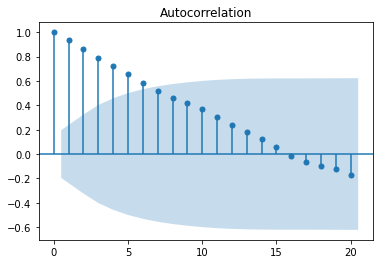

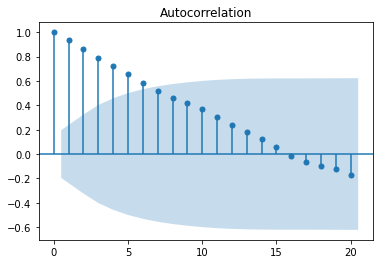

In [9]:
plot_acf(arr_lag_0)

PACF is the linear relationship after we filter out the linear influence of the random variables that lie in between

In [10]:
result['const'] = 1

In [11]:
model_R = sm.OLS(result['lag0'], result[['const','lag1']]).fit()
model_F = sm.OLS(result['lag0'], result[['const','lag1','lag2']]).fit()

In [12]:
SSE_R = np.square(model_R.resid).sum()
SSE_F = np.square(model_F.resid).sum()

In [13]:
np.sqrt((SSE_R - SSE_F) / SSE_R)

0.08737315490587608

In [14]:
pacf(arr_lag_0, nlags=3)

array([ 1.        ,  0.9428098 , -0.11094442, -0.00627537])

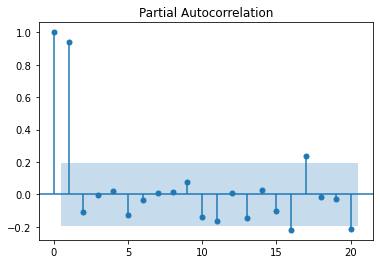

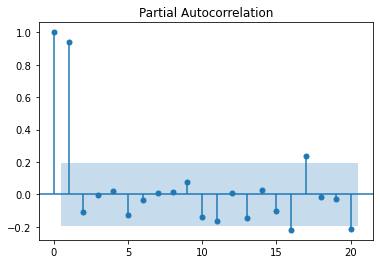

In [15]:
plot_pacf(arr_lag_0)

#### We have both ACF and PACF. To spot a pattern of AR model, we use PACF

In [16]:
df = pd.read_csv(os.path.join(filedir, 'google_stock.csv'), index_col=0)
df

,price
2/7/2005,196.03
2/8/2005,198.64
2/9/2005,191.58
2/10/2005,187.98
2/11/2005,187.40
...,...
6/30/2005,294.15
7/1/2005,291.25
7/5/2005,295.71
7/6/2005,291.52


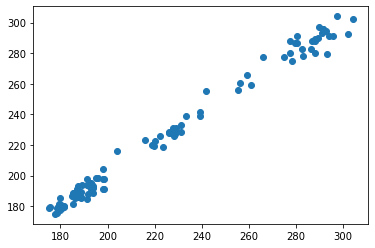

In [17]:
plt.scatter(df['price'], df['price'].shift(-1))

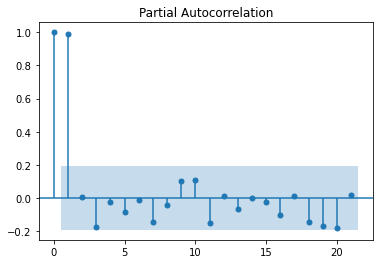

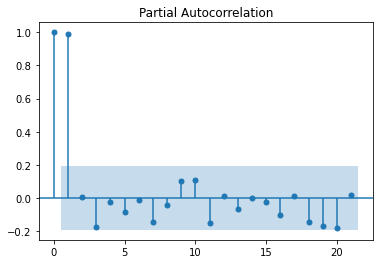

In [18]:
plot_pacf(df['price'])

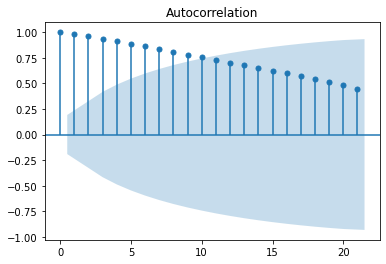

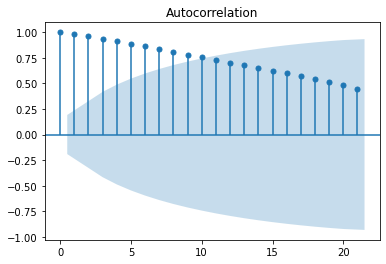

In [19]:
plot_acf(df['price'])

#### 2. AR Errors

#### One important application of a simple AR(1) model is to model errors that have autocorrelation. Recall that the starting point is, when we do OLS, we need the assumption of error independence. In practice, it's rare to have such independence; instead, we can usually observe AR(1) error

$$
y_t = X_t \beta + \epsilon_t
$$

$$
\epsilon_t = \rho \epsilon_{t-1} + \omega_t
$$

It's important to remember that here $|\rho|$ must be smaller than 1; And $\omega_t$ follows iid normal distribution $N(0,\sigma^2)$

$E[\epsilon_t] = 0$ AND $Var(\epsilon_t) = \frac{\sigma^2}{1-\rho^2}$ AND $corr(\epsilon_t, \epsilon_{t-1}) = \rho$

We can use PACT plots to help us assess appropriate lags for the errors in a regression model. In other words, we explore the regression residuals

#### In addition to PACF plots, we can use formal tests, such as Durbin-Watson Test and Ljung-Box Q Test

#### 2.1 Durbin-Watson Test

DW test is to test AR(1) errors. The null hypothesis is $\rho=0$. If it's true, $\epsilon_t = \omega_t$

The DW test statistic varies from 0 to 4, with values between 0 and 2 indicating positive autocorrealtion, 2-4 means negative autocorrelation

In [20]:
df = pd.read_csv(os.path.join(filedir, 'blaisdell.txt'), sep='\t')
df

,time,comsales,indsales
0,1,20.96,127.3
1,2,21.40,130.0
2,3,21.96,132.7
3,4,21.52,129.4
4,5,22.39,135.0
5,6,22.76,137.1
6,7,23.48,141.2
7,8,23.66,142.8
8,9,24.10,145.5
9,10,24.01,145.3


In [21]:
y = df['comsales']
X = df[['indsales']]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

/Users/yuehuazhuang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               comsales   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.489e+04
Date:                Fri, 01 Jul 2022   Prob (F-statistic):           1.01e-27
Time:                        13:26:18   Log-Likelihood:                 21.730
No. Observations:                  20   AIC:                            -39.46
Df Residuals:                      18   BIC:                            -37.47
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4548      0.214     -6.793      0.000      -1.905      -1.005
indsales       0.1763      0.001    122.017      0.000       0.173       0.179
==============================================================================
Omnibus:                        0.074   Durbin-Watson:                   0.735
Prob(Omnibus):                  0.964   Jarque-Bera (JB):                0.300
Skew:                          -0.032   Prob(JB):                        0.861
Kurtosis:                       2.404   Cond. No.                     1.65e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.65e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

To get the pvalue of DW test, use DW table: https://online.stat.psu.edu/stat501/sites/stat501/files/14outliers/durbinwatson.pdf

#### 2.2 Ljung-Box Q Test

This is used to test whether or not observations over time are random and independent. So it's testing AR(k), and k is given

The LB statistic is approx chi-squared distribution, and the null hypothesis is that the autocorrelations up to lag k are all 0

In [22]:
sm.stats.acorr_ljungbox(model.resid, lags=[1], return_df=True)

,lb_stat,lb_pvalue
1,9.075157,0.002591


#### 3. Remedial Mesures: what to do with AR errors?

<ol>
    <li>Cochrane-Orcutt Procedure: estimate $\rho$ for $\epsilon_t = \rho \epsilon_{t-1} + \omega_t$ by performing a regression through the origin; Transform the variables and then do the regression</li>
    <li>Hildreth-Lu Procedure</li>
    <li>First Differences Procedure</li>
</ol> 

#### 3-1. Cochrane-Orcutt Procedure

In [23]:
df = pd.read_csv(os.path.join(filedir, 'blaisdell.txt'), sep='\t')
y = df['comsales']
X = df[['indsales']]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

/Users/yuehuazhuang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               comsales   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.489e+04
Date:                Fri, 01 Jul 2022   Prob (F-statistic):           1.01e-27
Time:                        13:26:18   Log-Likelihood:                 21.730
No. Observations:                  20   AIC:                            -39.46
Df Residuals:                      18   BIC:                            -37.47
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4548      0.214     -6.793      0.000      -1.905      -1.005
indsales       0.1763      0.001    122.017      0.000       0.173       0.179
==============================================================================
Omnibus:                        0.074   Durbin-Watson:                   0.735
Prob(Omnibus):                  0.964   Jarque-Bera (JB):                0.300
Skew:                          -0.032   Prob(JB):                        0.861
Kurtosis:                       2.404   Cond. No.                     1.65e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.65e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Regress resid against lag1 of resid, estimate the parameter $\rho$ in the formula $\epsilon_t = \rho \epsilon_{t-1} + \omega_t$

In [24]:
resids = model.resid

In [25]:
tmp = pd.DataFrame({"resids":resids})
tmp['lag1'] = tmp['resids'].shift(1)
tmp = tmp.dropna()
tmp_model = sm.OLS(tmp['resids'], tmp[['lag1']]).fit()
tmp_model.params

lag1    0.631164
dtype: float64

Transform y and x in this way: $y_t = y_{t} - \rho * y_{t-1} $, $X_t = X_{t} - \rho * X_{t-1} $ 

In [26]:
r = 0.631164
y_tranformed = y - r * y.shift(1)
y_tranformed = y_tranformed.dropna()
X_tranformed = X - r * X.shift(1)
X_tranformed = X_tranformed.dropna()
X_tranformed['const'] = 1

Fit OLS with new X and y

In [27]:
sm.OLS(y_tranformed, X_tranformed).fit().summary()

/Users/yuehuazhuang/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               comsales   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     3454.
Date:                Fri, 01 Jul 2022   Prob (F-statistic):           4.43e-21
Time:                        13:26:18   Log-Likelihood:                 25.411
No. Observations:                  19   AIC:                            -46.82
Df Residuals:                      17   BIC:                            -44.93
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3941      0.167     -2.357      0.031      -0.747      -0.041
indsales       0.1738      0.003     58.767      0.000       0.168       0.180
==============================================================================
Omnibus:                        0.612   Durbin-Watson:                   1.650
Prob(Omnibus):                  0.736   Jarque-Bera (JB):                0.672
Skew:                           0.317   Prob(JB):                        0.715
Kurtosis:                       2.332   Cond. No.                         614.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Notice that now the DW statistics is closer to 2

Finally, we need to transform the intercept paramter by calculating $\beta_0 = \frac{\beta_0}{1-\rho}$ and $se(\beta_0) = \frac{se(\beta_0)}{1-\rho}$

In [28]:
-0.3941 / (1-r)

-1.068496567580171

In [29]:
0.167 / (1-r)

0.45277575941610904

The final regression result is:
$$
comsales = -1.068 + 0.1738 * indsales
$$
Instead of the initial fitting result:
$$
comsales = -1.4548 + 0.1763 * indsales
$$

In [30]:
df.columns

Index(['time', 'comsales', 'indsales'], dtype='object')

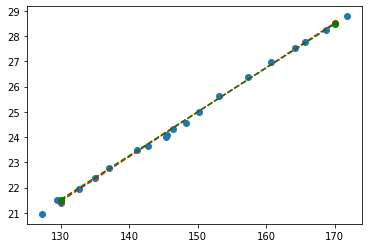

In [31]:
plt.scatter(df['indsales'], df['comsales'])
before_start_point = [130, -1.4548 + 0.1763 * 130]
before_end_point = [170, -1.4548 + 0.1763 * 170]
after_start_point = [130, -1.068 + 0.1738 * 130]
after_end_point = [170, -1.068 + 0.1738 * 170]
x_values = [before_start_point[0], before_end_point[0]]
y_values = [before_start_point[1], before_end_point[1]]
plt.plot(x_values, y_values, 'ro', linestyle="--")
x_values = [after_start_point[0], after_end_point[0]]
y_values = [after_start_point[1], after_end_point[1]]
plt.plot(x_values, y_values, 'go', linestyle="--")

In [32]:
y = df['comsales']
X = df[['indsales']]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

/Users/yuehuazhuang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


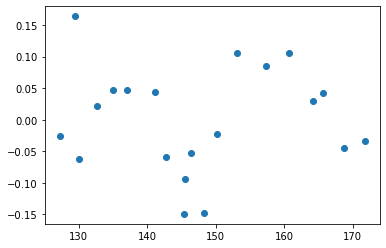

In [33]:
plt.scatter(df['indsales'], model.resid)

In [34]:
params = np.array([-1.068, 0.17376])

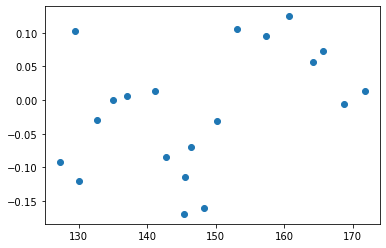

In [35]:
plt.scatter(df['indsales'], y - X.values @ params) 

#### 3-2. Hildreth-Lu Procedure: skip

#### 3-3. First Differences Procedure

In [36]:
df = pd.read_csv(os.path.join(filedir, 'blaisdell.txt'), sep='\t')
y = df['comsales'].diff().dropna()
X = df[['indsales']].diff().dropna()

In [37]:
sm.OLS(y, X).fit().summary()

/Users/yuehuazhuang/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               comsales   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.983
Method:                 Least Squares   F-statistic:                              1093.
Date:                Fri, 01 Jul 2022   Prob (F-statistic):                    1.44e-17
Time:                        13:26:18   Log-Likelihood:                          24.246
No. Observations:                  19   AIC:                                     -46.49
Df Residuals:                      18   BIC:                                     -45.55
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
indsales       0.1685      0.005     33.063      0.000       0.158       0.179
==============================================================================
Omnibus:                        0.373   Durbin-Watson:                   1.739
Prob(Omnibus):                  0.830   Jarque-Bera (JB):                0.515
Skew:                           0.197   Prob(JB):                        0.773
Kurtosis:                       2.296   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Fit through origin. And then calculate the intercept by $\hat{\beta}_0 = \bar{y} - (\hat{\beta}_1 \bar{x}_1 + ... + \hat{\beta}_{p-1} \bar{x}_{p-1})$

In [38]:
df['comsales'].mean() - 0.1685 * df['indsales'].mean()

-0.30581249999999827

$$
comsales = -0.3058 + 0.1685 * indsales
$$

#### 4. Forecasting when AR(1) error

It seems that we are doing for now is quite uesless... But why? When forecasting, we have more than a linear model. We also consider the lagged error term.

$$
F_t = \hat{y}_t + e_t = \hat{y}_t + r e_{t-1} = \hat{y}_t + r (y_{t-1} - \hat{y}_{t-1})
$$

For example, we go back to the Cochrane-Orcutt procedure. Suppose we wish to forecast the next y, when next t is projected to be $175.3 million

The final regression result is $r=0.631164$
, and 
$$
comsales = -1.068 + 0.1738 * indsales
$$


In [42]:
df = pd.read_csv(os.path.join(filedir, 'blaisdell.txt'), sep='\t')
df.tail(1)

,time,comsales,indsales
19,20,28.78,171.7


In [44]:
yhat_t = -1.068 + 0.1738 * 175.3
yhat_tm1 = -1.068 + 0.1738 * 171.7
y_tm1 = 28.78
r = 0.631164
F_t = yhat_t + r * (y_tm1 - yhat_tm1)
print(yhat_t, F_t)

29.399140000000003 29.403267812560003


#### We spent much time on AR(1) error, $y_t = X_t \beta + \epsilon_t$ and $\epsilon_t = \rho \epsilon_{t-1} + \omega_t$; this is not equivalent to AR(1) model where $y_t = \beta_0 + \beta_1 y_{t-1} + \epsilon_t$